# K-Means Clustering: Segmentação de Clientes (RFM)

Diferente da abordagem supervisionada (Árvore/KNN) focada na previsão de um rótulo (Cancelamento), utilização de Aprendizado Não Supervisionado para descoberta de grupos naturais de clientes.

Aplicação da técnica **RFM (Recency, Frequency, Monetary)**, amplamente utilizada em marketing e e-commerce para definição do perfil do consumidor.

## 1. Importação de Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import datetime as dt

%matplotlib inline
sns.set_style("whitegrid")

## 2. Carga e Preparação dos Dados

Carregamento da base original e realização da limpeza inicial, com foco apenas em transações válidas contendo identificação de cliente (`CustomerID`).

In [ ]:
df = pd.read_csv('../assets/data.csv', encoding='ISO-8859-1')

df = df.dropna(subset=['CustomerID'])
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)] # Apenas compras válidas (sem devoluções ou erros)

# Tratamento de Data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"Dados limpos: {df.shape}")
df.head()

## 3. Engenharia de Features (RFM)


Para clusterização de clientes, transformação dos dados transacionais (uma linha por produto) em dados de clientes (uma linha por cliente).

Criação do dataset **RFM**:
- **Recency (Recência):** Dias desde a última compra.
- **Frequency (Frequência):** Quantidade de compras únicas (Invoices).
- **Monetary (Monetário):** Total gasto pelo cliente.

In [2]:
# Data de referência (dia seguinte à última compra da base)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Cálculo do Total Gasto por linha
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

# Agrupamento por Cliente (RFM)
rfm = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recência
    'InvoiceNo': 'nunique',                                  # Frequência
    'TotalSum': 'sum'                                        # Monetário
})

# Renomeando colunas
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

print("Amostra da Base RFM:")
display(rfm.head())

Amostra da Base RFM:


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


## 4. Pré-processamento: Escalonamento

Sensibilidade do K-Means à escala. Devido à variação de 'Monetary' (milhares) e 'Frequency' (unidades), necessidade de normalização dos dados (StandardScaler) para equilíbrio das distâncias.

*Nota: Aplicação de Log Transformation prévia para redução da assimetria (skewness) dos dados financeiros.*

In [3]:
# Log transform para lidar com outliers extremos de valor gasto
rfm_log = np.log1p(rfm)

# Normalização (StandardScaler)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Transformando de volta em DataFrame para facilitar uso
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

## 5. Método do Cotovelo (Elbow Method)

Teste de valores de K (número de grupos) de 1 a 10 para identificação do ponto de estabilização da inércia (erro).

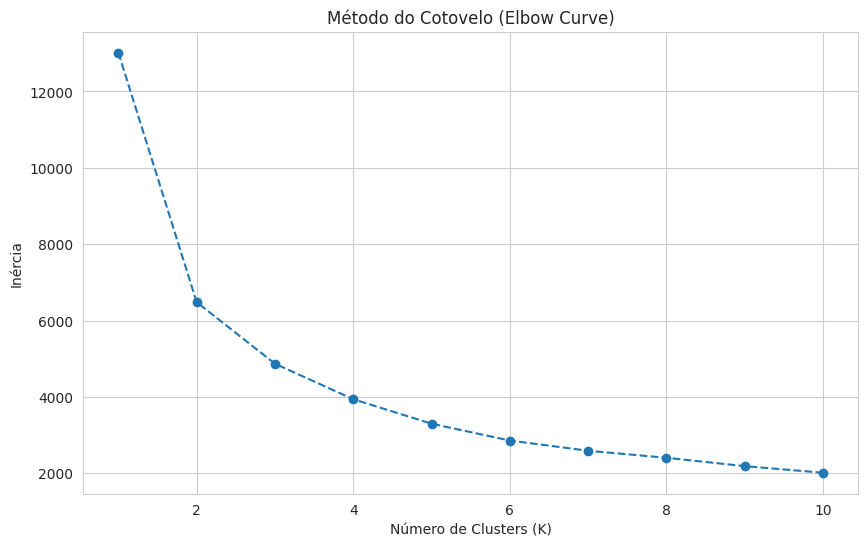

In [5]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Método do Cotovelo (Elbow Curve)')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia')
plt.show()

## 6. Treinamento e Clusterização

Baseado na curva acima (o "cotovelo" geralmente aparece em K=3 ou K=4), escolha de **K=3** para criação de grupos interpretáveis (ex: Bronze, Prata, Ouro).

In [7]:
k_final = 3
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init='auto')
kmeans.fit(rfm_scaled_df)

# Atribuindo os clusters aos dados originais (sem escala) para interpretação
rfm['Cluster'] = kmeans.labels_

print(f"Clusterização concluída com {k_final} grupos.")
print(rfm['Cluster'].value_counts())

Clusterização concluída com 3 grupos.
Cluster
2    1866
0    1696
1     776
Name: count, dtype: int64


## 7. Análise e Interpretação dos Resultados

Análise das médias de cada cluster para entendimento do perfil do cliente.

            Recency  Frequency     Monetary
Cluster                                    
0         44.463443   3.368514  1257.688940
1         17.070876  13.274485  7865.636662
2        167.613076   1.349411   361.539877


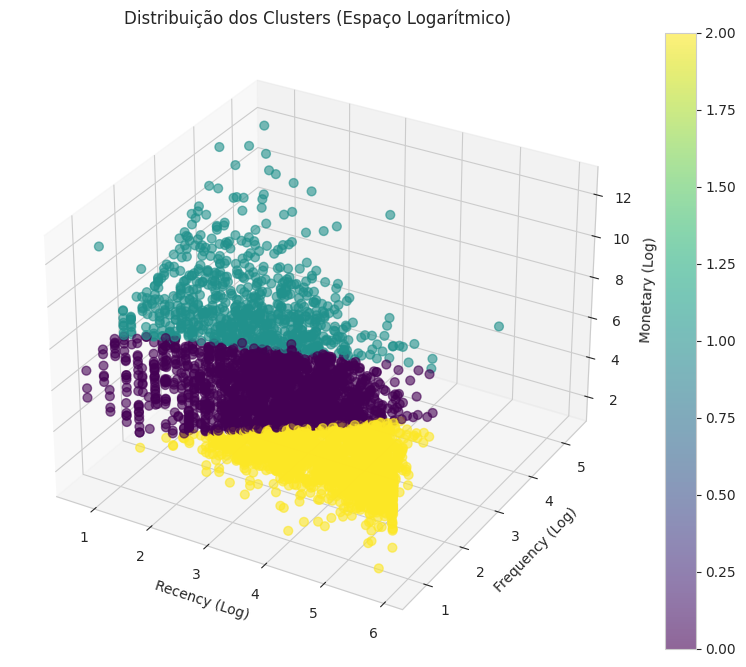

In [8]:
# Médias por Cluster
cluster_avg = rfm.groupby('Cluster').mean()
print(cluster_avg)

# Visualização 3D (Recency vs Frequency vs Monetary)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Cores baseadas no cluster
sc = ax.scatter(rfm_log['Recency'], rfm_log['Frequency'], rfm_log['Monetary'], 
                c=rfm['Cluster'], cmap='viridis', s=40, alpha=0.6)

ax.set_xlabel('Recency (Log)')
ax.set_ylabel('Frequency (Log)')
ax.set_zlabel('Monetary (Log)')
plt.title('Distribuição dos Clusters (Espaço Logarítmico)')
plt.colorbar(sc)
plt.show()

## Conclusão
 
Aplicação do K-Means na base RFM permitindo a segmentação dos clientes em 3 perfis:
 
1.  **Cluster 0 (Provável: "Novos ou Baixo Valor"):** Clientes com recência alta ou valor gasto baixo.
2.  **Cluster 1 (Provável: "Leais" ou "Intermediários"):** Compram com certa frequência e gastam um valor médio.
3.  **Cluster 2 (Provável: "VIPs" ou "Champions"):** Clientes que compraram recentemente, compram muito frequentemente e gastam valores altos.

Essa segmentação viabiliza estratégias de marketing diferenciadas, como campanhas de retenção para o Cluster 0 e programas de fidelidade VIP para o Cluster 2.